In [21]:
import igraph as ig
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score as AMI
import matplotlib.pyplot as plt

In [2]:
datadir='../Datasets/'
abcd_path = 'ABCD/utils/'

### Problem 1

Run various clustering algorithms (ECG, Louvain, Infomap, Label Propagation, Girvan-Newman, and CNM) for the karate club graph. For each algorithm tested, compare the partition found by the algorithm with the ground-truth (two communities) by computing the AMI score

In [3]:
z = ig.Graph.Famous('zachary')
z.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]

In [3]:
# copied GitHub code to add ECG to the choice of community algorithms
def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part
ig.Graph.community_ecg = community_ecg

ECG:

In [5]:
ecg = z.community_ecg().membership
print('AMI:',AMI(z.vs['comm'],ecg))

AMI: 0.5805154226518418


Louvain:

In [6]:
louvain = z.community_multilevel().membership
print('AMI:',AMI(z.vs['comm'],louvain))

AMI: 0.5653497612707893


Infomap:

In [7]:
infomap = z.community_infomap().membership
print('AMI:',AMI(z.vs['comm'],infomap))

AMI: 0.687422347904921


Label Propagation:

In [8]:
lp = z.community_label_propagation().membership
print('AMI:',AMI(z.vs['comm'],lp))

AMI: 0.5443932646993975


Girvan-Newman

In [9]:
gn = z.community_edge_betweenness()
print('AMI:',AMI(z.vs['comm'],gn.as_clustering(n=2).membership))

AMI: 0.8327564079186137


CNM:

In [10]:
cnm = z.community_fastgreedy()
print('AMI:',AMI(z.vs['comm'],cnm.as_clustering(n=2).membership))

AMI: 0.8334659946350965


### Problem 2

Run various clustering algorithms (ECG, Louvain, Infomap, Label Propagation, Girvan-Newman and CNM) on the GitHub ml graph. Which algorithms produce similar results? In order to answer this question, for each pair of algorithms, find the AMI score between the two results. 

In [3]:
## read edges and make graph
github_df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
gh = ig.Graph.DataFrame(github_df, directed=False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

lbl = ['web','ml']     ## node labels
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the mlsubgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])

In [11]:
## run various clustering algorithms
ecg = gh_ml.community_ecg().membership
louvain = gh_ml.community_multilevel().membership
infomap = gh_ml.community_infomap().membership
lp = gh_ml.community_label_propagation().membership
cnm = gh_ml.community_fastgreedy().as_clustering().membership

In [ ]:
## the Girvan-Newman was not included as it was too slow
gn = gh_ml.community_edge_betweenness().membership

In [13]:
clustering_algorithms = [ecg, louvain, infomap, lp, cnm]
names = ['ECG', 'Louvain', 'Infomap', 'Label Propagation', 'CNM']
for i in range(len(clustering_algorithms)):
    for j in range(i):
        print('AMI between {0} and {1} algorithms: {2}'.format(names[i], names[j], AMI(clustering_algorithms[i],clustering_algorithms[j])))

AMI between Louvain and ECG algorithms: 0.6142065735152655
AMI between Infomap and ECG algorithms: 0.5721087219995244
AMI between Infomap and Louvain algorithms: 0.49278914886975994
AMI between Label Propagation and ECG algorithms: 0.4773705026131031
AMI between Label Propagation and Louvain algorithms: 0.5716413602349016
AMI between Label Propagation and Infomap algorithms: 0.27687935405599395
AMI between CNM and ECG algorithms: 0.554631691686149
AMI between CNM and Louvain algorithms: 0.5927389075550022
AMI between CNM and Infomap algorithms: 0.4567442413372447
AMI between CNM and Label Propagation algorithms: 0.614989191440958


### Problem 5

Take the ABCD graph we used to test quality measures. Check node roles. Compute how many nodes we have in each family (recall there are 4 families of non-hubs and 3 families of hubs). Plot the $(z(v), p(v))$ scores for all nodes as we did in Figure 5.3 for the karate club graph. 

In [4]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1]-1 for x in g.vs]

In [19]:
## compute internal degrees
in_deg_0 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==0 and g.vs['comm'][e.tuple[1]]==0],
                            delete_vertices=False).degree()
in_deg_1 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==1 and g.vs['comm'][e.tuple[1]]==1],
                            delete_vertices=False).degree()
in_deg_2 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==2 and g.vs['comm'][e.tuple[1]]==2],
                            delete_vertices=False).degree()

## compute z (normalized within-module degree)
g.vs['in_deg'] = [in_deg_0[i] + in_deg_1[i] + in_deg_2[i] for i in range(g.vcount())]
mu = [np.mean([x for x in in_deg_0 if x>0]),np.mean([x for x in in_deg_1 if x>0]),np.mean([x for x in in_deg_2 if x>0])]
sig = [np.std([x for x in in_deg_0 if x>0],ddof=1),np.std([x for x in in_deg_1 if x>0],ddof=1),np.std([x for x in in_deg_2 if x>0],ddof=1)]
g.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in g.vs]

## computing p (participation coefficient)
g.vs['deg'] = g.degree()
g.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in g.vs]
g.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in g.vs]
D = pd.DataFrame(np.array([g.vs['z'],g.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head()

,z,p
5,2.558409,0.244898
24,2.380025,0.260355
2,2.367309,0.277778
31,2.367309,0.165289
22,1.890355,0.355030


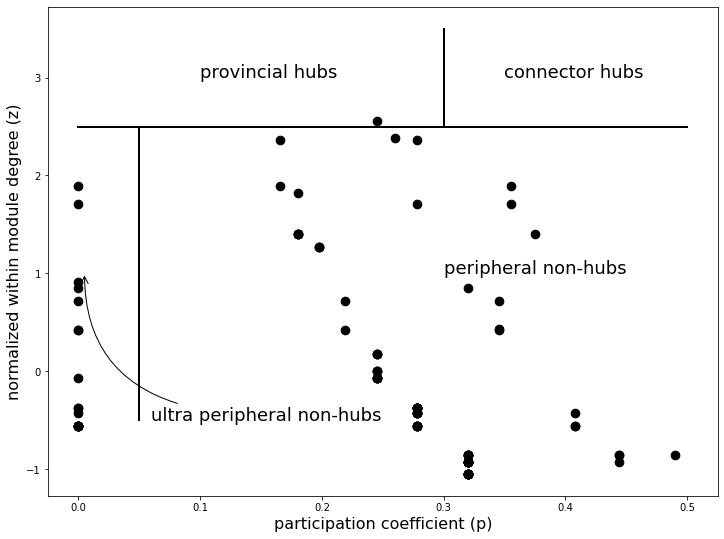

In [39]:
## Plotting z(v) vs p(v) scores for all nodes
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(g.vs['p'],g.vs['z'],marker='o',s=75, color='k')

plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([.05, .05], [-.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([0.3, 0.3], [2.5, 3.5], color='k', linestyle='-', linewidth=2)

ax.annotate('provincial hubs',(.1,3), fontsize=18)
ax.annotate('connector hubs',(.35,3), fontsize=18)
ax.annotate('peripheral non-hubs',(.3,1.), fontsize=18)
ax.annotate('ultra peripheral non-hubs',(0.005,1.0),xytext=(.06,-0.5), fontsize=18,
             arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

plt.xlabel('participation coefficient (p)',fontsize=16)
plt.ylabel('normalized within module degree (z)',fontsize=16);

### Problem 6

Compare time complexities of various clustering algorithms (ECG, Louvain, Infomap, Label Propagation, Girvan-Newman, CNM) using an ABCD synthetic graph with different number of nodes, say, $n=100, 200, 400, 800, 1600, ...$. Which algorithm is the slowest, which one is the fastest?

In [40]:
g100 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
g200 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_200.dat',directed=False)
g400 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_400.dat',directed=False)
g800 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_800.dat',directed=False)
g1600 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1600.dat',directed=False)

ECG:

In [42]:
%%time
ecg = g100.community_ecg().membership

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 28 ms


In [43]:
%%time
ecg = g200.community_ecg().membership

CPU times: user 49.3 ms, sys: 0 ns, total: 49.3 ms
Wall time: 47.1 ms


In [44]:
%%time
ecg = g400.community_ecg().membership

CPU times: user 54.6 ms, sys: 0 ns, total: 54.6 ms
Wall time: 53.9 ms


In [45]:
%%time
ecg = g800.community_ecg().membership

CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 239 ms


In [46]:
%%time
ecg = g1600.community_ecg().membership

CPU times: user 416 ms, sys: 0 ns, total: 416 ms
Wall time: 414 ms


Louvain:

In [47]:
%%time
louvain = g100.community_multilevel().membership

CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 3.17 ms


In [48]:
%%time
louvain = g200.community_multilevel().membership

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.98 ms


In [49]:
%%time
louvain = g400.community_multilevel().membership

CPU times: user 8.45 ms, sys: 12 µs, total: 8.46 ms
Wall time: 7.98 ms


In [50]:
%%time
louvain = g800.community_multilevel().membership

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.9 ms


In [51]:
%%time
louvain = g1600.community_multilevel().membership

CPU times: user 18.4 ms, sys: 3.64 ms, total: 22 ms
Wall time: 21.6 ms


Infomap:

In [52]:
%%time
infomap = g100.community_infomap().membership

CPU times: user 31.2 ms, sys: 187 µs, total: 31.4 ms
Wall time: 45.2 ms


In [53]:
%%time
infomap = g200.community_infomap().membership

CPU times: user 67.8 ms, sys: 0 ns, total: 67.8 ms
Wall time: 67.4 ms


In [54]:
%%time
infomap = g400.community_infomap().membership

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 157 ms


In [55]:
%%time
infomap = g800.community_infomap().membership

CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 148 ms


In [56]:
%%time
infomap = g1600.community_infomap().membership

CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 349 ms


Label Propagation:

In [57]:
%%time
lp = g100.community_label_propagation().membership

CPU times: user 407 µs, sys: 34 µs, total: 441 µs
Wall time: 449 µs


In [58]:
%%time
lp = g200.community_label_propagation().membership

CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 3.11 ms


In [60]:
%%time
lp = g400.community_label_propagation().membership

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 3.14 ms


In [61]:
%%time
lp = g800.community_label_propagation().membership

CPU times: user 4.72 ms, sys: 49 µs, total: 4.77 ms
Wall time: 4.6 ms


In [62]:
%%time
lp = g1600.community_label_propagation().membership

CPU times: user 7.98 ms, sys: 0 ns, total: 7.98 ms
Wall time: 7.27 ms


CNM:

In [63]:
%%time
cnm = g100.community_fastgreedy().as_clustering().membership

CPU times: user 1.37 ms, sys: 117 µs, total: 1.48 ms
Wall time: 1.13 ms


In [64]:
%%time
cnm = g200.community_fastgreedy().as_clustering().membership

CPU times: user 2.32 ms, sys: 0 ns, total: 2.32 ms
Wall time: 2.33 ms


In [65]:
%%time
cnm = g400.community_fastgreedy().as_clustering().membership

CPU times: user 11 ms, sys: 229 µs, total: 11.2 ms
Wall time: 10.7 ms


In [66]:
%%time
cnm = g800.community_fastgreedy().as_clustering().membership

CPU times: user 42.2 ms, sys: 0 ns, total: 42.2 ms
Wall time: 41.9 ms


In [67]:
%%time
cnm = g1600.community_fastgreedy().as_clustering().membership

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 105 ms


Girvan-Newmann

In [69]:
%%time
gn = g100.community_edge_betweenness()

CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 162 ms


In [70]:
%%time
gn = g200.community_edge_betweenness()

CPU times: user 1.12 s, sys: 1.75 ms, total: 1.12 s
Wall time: 1.11 s


In [71]:
%%time
gn = g400.community_edge_betweenness()

CPU times: user 8.18 s, sys: 0 ns, total: 8.18 s
Wall time: 8.14 s


In [ ]:
%%time
gn = g800.community_edge_betweenness()

In [ ]:
%%time
gn = g1600.community_edge_betweenness()